In [13]:
from keras import Model
from keras.applications import VGG16
from keras.callbacks import ModelCheckpoint, Callback
from keras.layers import Input, Dense, LSTM, Embedding, GRU, Flatten, Dropout, BatchNormalization, RepeatVector, concatenate
from keras.models import model_from_json
from keras.optimizers import RMSprop
from keras.preprocessing.sequence import pad_sequences
from nltk.translate.bleu_score import corpus_bleu, sentence_bleu
from PIL import Image
from tqdm import tqdm_notebook as tqdm

import coco_parse
import flickr8k_parse
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import text_processing
import utils

In [2]:
train_vocab = text_processing.Vocabulary()
train_vocab.load_vocabulary()

In [3]:
batch_size = 64

initial_state_size = 512
embedding_out_size = 512
number_of_gru = 1
batch_norm = False
dropout = False
path_checkpoint = './decoders/VGG16_GRU_flickr8k_3l_64b.hdf5'
model_path = './models/VGG16_GRU_3l.json'

In [38]:
transfer_values = np.load('./cnn_features/vgg16_flickr8k_train.npy')

In [4]:
with open(model_path, 'r') as json_file:
    loaded_model_json = json_file.read()

decoder_model = model_from_json(loaded_model_json)
# load weights into new model
decoder_model.load_weights(path_checkpoint)

Instructions for updating:
Colocations handled automatically by placer.


In [5]:
decoder_model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
decoder_input (InputLayer)      (None, None)         0                                            
__________________________________________________________________________________________________
encoder_input (InputLayer)      (None, 4096)         0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, None, 512)    3774976     decoder_input[0][0]              
__________________________________________________________________________________________________
encoder_reduction (Dense)       (None, 512)          2097664     encoder_input[0][0]              
__________________________________________________________________________________________________
GRU1 (GRU)

### Checkpoints

During the training process, it is a good idea to save the weights periodically.

In [7]:
try:
    decoder_model.load_weights(path_checkpoint)
except:
    print("Error while loading weights")

### Encoder model for predictions

In [9]:
VGG_model = VGG16(include_top=True, weights='imagenet')
transfer_layer = VGG_model.get_layer('fc2')
VGG_transfer_model = Model(inputs=VGG_model.input, outputs=transfer_layer.output)
input_layer = VGG_model.get_layer('input_1')
VGG_image_size = input_layer.input_shape[1:3]

In [11]:
def generate_caption(image, model_image_size, decoder_model, transfer_model, vocabulary, transfer_values=False, beam_size=3, max_caption_len=30):
    """
    Generates a caption for a given image
    
    """
    if transfer_values: 
        input_transfer_values = image.reshape((1, 4096))
    else:
        img = utils.image_preprocessing(image, model_image_size)
        image_batch = np.expand_dims(img, axis=0)
        input_transfer_values = transfer_model.predict(image_batch)
    
    decoder_inputs = np.zeros(shape=(1, max_caption_len), dtype=np.int)
    
    captions = [[[vocabulary.get_id_by_word('<sos>')], 0.0]]
    
    token = vocabulary.get_id_by_word('<sos>')
    tokens = token * beam_size
    scores = [0.0] * 3
    
    for i in range(max_caption_len):
        tmp_caps = []
        for caption in captions:
            sentence, score = caption
            if sentence[-1] == vocabulary.get_id_by_word('<eos>'):
                tmp_caps.append(caption)
                continue
            
            decoder_inputs[0, :len(sentence)] = sentence

            input_data = {
                'encoder_input': input_transfer_values,
                'decoder_input': decoder_inputs
            }

            decoder_output = decoder_model.predict(input_data)
            candidates = decoder_output[0, i, :].argsort()[-beam_size:]
            
            for candidate in candidates:
                sentence.append(candidate)
                caption = [sentence, score + np.log(decoder_output[0, i, candidate])]
                sentence = sentence[:-1]
                tmp_caps.append(caption)
        captions = sorted(tmp_caps, key=lambda x: x[1], reverse=True)[:beam_size]
    
    for i in range(beam_size):
        captions[i][1] /= len(captions[i][0])
        
    captions = sorted(tmp_caps, key=lambda x: x[1], reverse=True)
    
    if not transfer_values:
        plt.imshow(img)
        plt.show()
        for i in range(beam_size):
            print(" ".join([vocabulary.get_word_by_id(x) for x in captions[i][0][1:-1]]), captions[i][1])
            
    return [vocabulary.get_word_by_id(x) for x in captions[0][0][1:-1]]

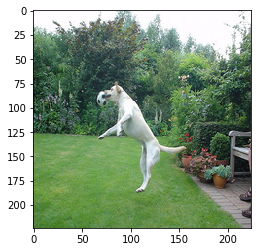

a black and white dog is running through a grassy area -0.6712957276747777


In [12]:
import tensorflow as tf
from tensorflow import keras

beam_size = 1
captions = generate_caption('D:/Flickr8k/images/224702242_a62aaa6dff.jpg', VGG_image_size, decoder_model, VGG_transfer_model, train_vocab, beam_size=beam_size)

In [18]:
captions

['a', 'dog', 'is', 'running', 'through', 'the', 'grass']

In [19]:
images_path = 'D:/Flickr8k/images/'
annotations_path = 'D:/Flickr8k/annotations/'
captions_file = 'D:/Flickr8k/annotations/Flickr8k.token.txt'
train_txt_path = 'D:/Flickr8k/annotations/Flickr_8k.trainImages.txt'
dev_txt_path = 'D:/Flickr8k/annotations/Flickr_8k.devImages.txt'
test_txt_path = 'D:/Flickr8k/annotations/Flickr_8k.testImages.txt'

filenames_with_all_captions = flickr8k_parse.generate_filenames_with_all_captions(captions_file, images_path)

test_filenames_with_all_captions = flickr8k_parse.generate_set(test_txt_path, filenames_with_all_captions, images_path)

test_captions = flickr8k_parse.make_list_of_captions(test_filenames_with_all_captions)

In [20]:
text_processing.preprocess_captions(test_captions)

In [21]:
references = []
for list_captions in test_captions:
    reference = []
    for caption in list_captions:
        reference.append(caption.split())
    references.append(reference)

In [22]:
references[0]

[['the',
  'dogs',
  'are',
  'in',
  'the',
  'snow',
  'in',
  'front',
  'of',
  'a',
  'fence'],
 ['the', 'dogs', 'play', 'on', 'the', 'snow'],
 ['two', 'brown', 'dogs', 'playfully', 'fight', 'in', 'the', 'snow'],
 ['two', 'brown', 'dogs', 'wrestle', 'in', 'the', 'snow'],
 ['two', 'dogs', 'playing', 'in', 'the', 'snow']]

In [23]:
transfer_values = np.load('./cnn_features/vgg16_flickr8k_test.npy')

In [24]:
def generate_test_captions(test_images, *args):
    """
    Generate captions for bunch of validation captions
    """
    captions = []
    for i, image in tqdm(enumerate(test_images)):
        captions.append(generate_caption(image, *args))
 
    return captions

In [25]:
generated_captions = generate_test_captions(transfer_values, VGG_image_size, decoder_model, VGG_transfer_model, train_vocab, True)

HBox(children=(IntProgress(value=1, bar_style='info', max=1), HTML(value='')))

KeyboardInterrupt: 

In [ ]:
len(generated_captions)

In [ ]:
num = 130
generated_captions[num]

In [ ]:
test_captions[num]

In [ ]:
test_captions_arr = []
for captions in test_captions:
    tmp_cap_list = []
    for caption in captions:
        tmp_cap_list.append(caption.split())
    test_captions_arr.append(tmp_cap_list)


In [ ]:
print('{:.3f}'.format(corpus_bleu(test_captions_arr, generated_captions, weights=(1,0,0,0)) * 100))

In [ ]:
print('{:.3f}'.format(corpus_bleu(test_captions_arr, generated_captions, weights=(0.5,0.5))* 100))

In [ ]:
print('{:.3f}'.format(corpus_bleu(test_captions_arr, generated_captions, weights=(0.33,0.33,0.33,0)) * 100))

In [ ]:
print('{:.3f}'.format(corpus_bleu(test_captions_arr, generated_captions, weights=(0.25,0.25,0.25,0.25)) * 100))